### Description:

This is a solution to a take-home assignment.

A copany has an app where you can choose between free and premium subscription. 
They decided to increase prices for premium subscription and ran an A/B test: for some users in different countries the price for a subscription was increased. Note, that price for a demo period (for premium subscription) didn't change.
Question: Should the company increase price for the premium subscription

Data description:
Premium subscription fee is incured monthly until user cancels it

There are 3 groups: test, control_1, control_2. For each of them:

files user_*.csv - user info:

uid – user id
age – user age
attraction_coeff – attraction coefficient (from 0 to 1000, \frac{likes}{views}*1000 
views
likes
coins – quantity of coins (in-app currency)
country  
visit_days – visits in days after registration (ex. in 1-st day after registration, then in 7th day after registration)
gender
age_filter_start  – user age search filter min (what is the minimum age he/she is searching for)
age_filter_end  – user age search filter max
views_count – how many views user received
was_premium – did user ever use premium (demo or purchased)
is_premium –  is user premium now
total_revenue – revenue
 
transactions_*.csv – user transaction info:
uid – user id
country
joined_at – registration date
paid_at – purchase date
revenue
payment_id 
from_page – from what page user came to payment page
product_type – product type (trial_premium, premium_no_trial, coins – premium for in-app currency, other_type – other)

## Executive summary (final answer)

The price should be increased.
Price increase has no statistically significant effect on ARPU or conversion (share of paid subscriptions)
At the same time, we see a statistically significant increase in ARPPU

That means that after price increase users neither switch to a free subscription, nor buy more premium.
But people who are using it now - agree to pay more for it: which increases ARPPU

### Detailed answer: with code 

In [14]:
# importing libraries
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal, levene, ttest_ind, norm
import seaborn as sns
import matplotlib.pyplot as plt


### Uploading the data

In [3]:
# User info
users_control_1 = pd.read_csv('/Users/igorrudakov/Desktop/Python_practice/snippets_and_portfolio/data_analytics_snippets/Data/users_control_1.csv',sep=';')
users_control_2 = pd.read_csv('/Users/igorrudakov/Desktop/Python_practice/snippets_and_portfolio/data_analytics_snippets/Data/users_control_2.csv',sep=';')
users_test =      pd.read_csv('/Users/igorrudakov/Desktop/Python_practice/snippets_and_portfolio/data_analytics_snippets/Data/users_test.csv',sep=';')

# Transactions info
transactions_control_1 = pd.read_csv('/Users/igorrudakov/Desktop/Python_practice/snippets_and_portfolio/data_analytics_snippets/Data/transactions_control_1.csv',sep=';')
transactions_control_2 = pd.read_csv('/Users/igorrudakov/Desktop/Python_practice/snippets_and_portfolio/data_analytics_snippets/Data/transactions_control_2.csv',sep=';')
transactions_test =      pd.read_csv('/Users/igorrudakov/Desktop/Python_practice/snippets_and_portfolio/data_analytics_snippets/Data/transactions_test.csv',sep=';')


transactions_control_1.paid_at = pd.to_datetime(transactions_control_1.paid_at)
transactions_control_1.joined_at = pd.to_datetime(transactions_control_1.joined_at)

transactions_control_2.paid_at = pd.to_datetime(transactions_control_2.paid_at)
transactions_control_2.joined_at = pd.to_datetime(transactions_control_2.joined_at)

transactions_test.paid_at = pd.to_datetime(transactions_test.paid_at)
transactions_test.joined_at = pd.to_datetime(transactions_test.joined_at)




### Exploring datasets

In [15]:
# head overview
users_control_2.head() # users_test  transactions_control_1  transactions_test 

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [29]:
transactions_control_1.info() # users_test  transactions_control_1  transactions_test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


### Formulating business task in terms of statistical experiment
Question: Should the company increase price for the premium subscription

The expected outcome of this: overall increase in revenue. If some users will pay more and many others churn - the revenue per paying user will increase, but overall revenue will fall. So we should track the perfomance of the experiment in terms of ARPU (average revenue per ALL users).

In [163]:
# first, lets see the ARPUs for different groups
# arpu of a test group

print('ARPU in groups')
print('Test group     : ' + str(users_test.total_revenue.mean() ) )
print('Control_1 group: ' + str(users_control_1.total_revenue.mean() ) )
print('Control_2 group: ' + str(users_control_2.total_revenue.mean() ) )


Test group     : 534.0803156917364
Control_1 group: 594.7619815668203
Control_2 group: 450.3841463414634


In [42]:
print('User count in groups')
print('Test group     : ' + str(users_test.uid.nunique() ) )
print('Control_1 group: ' + str(users_control_1.uid.nunique() ) )
print('Control_2 group: ' + str(users_control_2.uid.nunique() ) )

print('')
print('')

print('Users who PAYed for a premium')
print('Test group     : ' + str(users_test[(users_test.total_revenue > 0)].uid.nunique() ) )
print('Control_1 group: ' + str(users_control_1[(users_control_1.total_revenue > 0)].uid.nunique() ) )
print('Control_2 group: ' + str(users_control_2[(users_control_2.total_revenue > 0)].uid.nunique() ) )


User count in groups
Test group     : 4308
Control_1 group: 4340
Control_2 group: 4264


Users who PAYed for a premium
Test group     : 146
Control_1 group: 192
Control_2 group: 187


we see that:
- control_1 has higher ARPU than test
- at the same time control_2's ARPU is less that tests'
- control_1 shows higher ARPU than test

Let's also look at the distributions of datasets

<AxesSubplot:xlabel='total_revenue', ylabel='Count'>

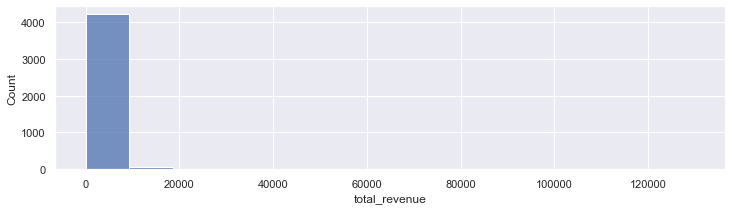

In [32]:
# test data
sns.set(rc={'figure.figsize':(12, 3)})
sns.histplot(users_test.total_revenue)    # users_control_1

Both distributions have lots of users that use free subscription or pay nothing.
For such distributions we can't use t-test and mannwhitney tests
I am going to use bootstrap to find distributions of ARPU for eacch of the groups
then I will find confidence intervals for the differences in distributions 

In [76]:
# def function that would generate many samples, take averages, find differences, and calculate CI with visualisation
def get_bootstrap(
    data_column_1, # first group
    data_column_2, # second group
    boot_it = 1000, # count of bootstrap samples
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
    boot_data = []
    sample_len = max(len(data_column_1), len(data_column_2))

    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(sample_len, replace = True).values
        samples_2 = data_column_2.sample(sample_len, replace = True).values
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    
    plt.hist(pd_boot_data, bins=50)
    
    plt.style.use('seaborn-deep')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot data')
    plt.show()
    return {'p_value' : min(p_1, p_2) * 2, 'boot_data':boot_data, 'ci':ci}

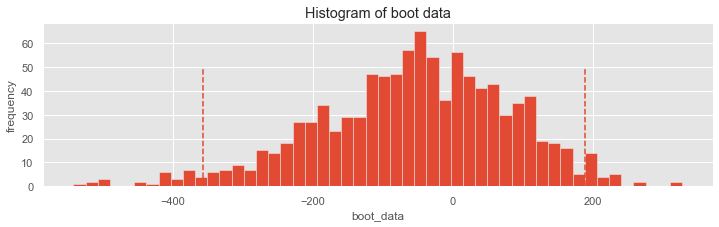

In [77]:
# Test group VS control 1
test_vs_c1 = get_bootstrap(users_test.total_revenue, users_control_1.total_revenue)

In [78]:
test_vs_c1['p_value']

0.6873239150978891

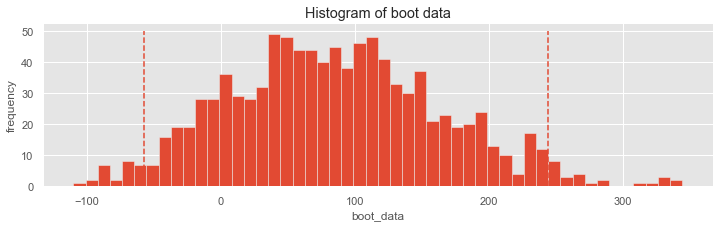

In [79]:
# Test group VS control 2
test_vs_c2 = get_bootstrap(users_test.total_revenue, users_control_2.total_revenue)

In [80]:
test_vs_c2['p_value']

0.2808185394404463

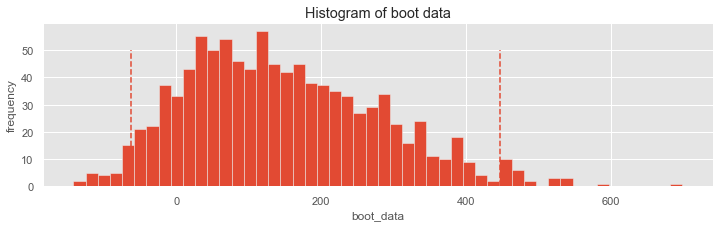

In [81]:
# control 1 VS control 2 --- AA test (if there is a difference - then control groups are spoiled and experiment is compromised)
c1_vs_c2 = get_bootstrap(users_control_1.total_revenue, users_control_2.total_revenue)

On all variations we see that confidence intervals incude 0 - therefore there is no evidence to support the hypothesis
that there is any effect/difference between groups.

It might be due to the large amount of users that use free subscription.
Next, we might want to evaluate whether there was a decrease in share of users that buy subscription

##### Testing for paying users

In [ ]:
test_paid = users_test[(users_test.total_revenue > 0)].uid.nunique()
c1_paid = [(users_control_1.total_revenue > 0)].uid.nunique()
c2_paid = [(users_control_2.total_revenue > 0)].uid.nunique()


In [83]:
# slightly change the function
def get_bootstrap_2(
    data_1, # first group
    data_2, # second group
    boot_it = 1000, # count of bootstrap samples
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
    boot_data = []
    sample_len = 1000
    
    for i in range(2000):
        a = data_1.sample(1000, replace=True)
        samples_1 = a[(a.total_revenue > 0)].uid.nunique() / a.uid.nunique()
        
        b = data_2.sample(1000, replace=True)
        samples_2 = b[(b.total_revenue > 0)].uid.nunique() / b.uid.nunique()

        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    
    plt.hist(pd_boot_data, bins=50)
    
    plt.style.use('seaborn-deep')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot data')
    plt.show()
    return {'p_value' : min(p_1, p_2) * 2, 'boot_data':boot_data, 'ci':ci}

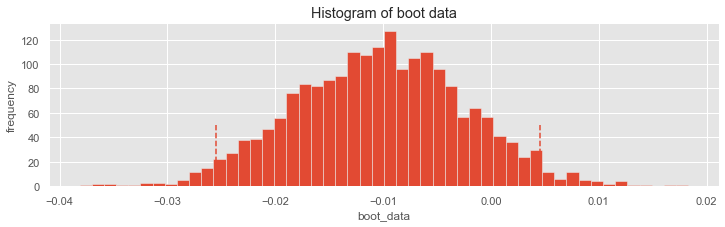

In [85]:
test_vs_c1 = get_bootstrap_2(users_test, users_control_1)

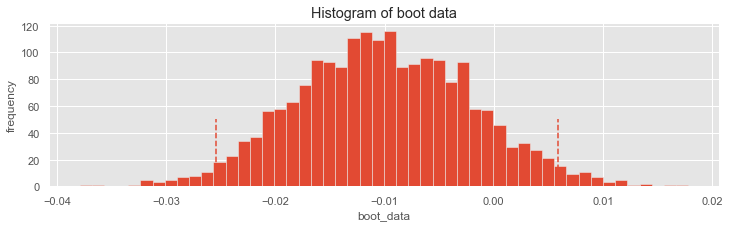

In [86]:
test_vs_c2 = get_bootstrap_2(users_test, users_control_2)

Increase in prices didn't affect the ARPU and the conversion.
There might be differences in different countries though

But, anyway, we should now check the differences in ARPPU - 

In [89]:
# Since it is faster - let's check for ARPPU first
test_paid_rev = users_test[(users_test.total_revenue > 0)].total_revenue
c1_paid_rev = users_control_1[(users_control_1.total_revenue > 0)].total_revenue
c2_paid_rev = users_control_2[(users_control_2.total_revenue > 0)].total_revenue


<AxesSubplot:xlabel='total_revenue', ylabel='Count'>

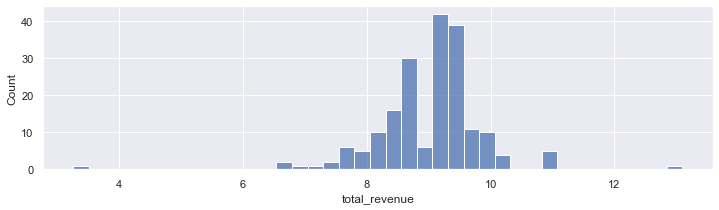

In [104]:
# explore distributions
sns.set(rc={'figure.figsize':(12,3)})
sns.histplot(np.log(test_paid_rev))    # c1_paid_rev  c2_paid_rev

At least they resemble normal distribution (with log, at least). So we can use t_test, and mannwhitneyu

In [116]:
# t-tests
print('Test VS C1 - t_test        : ' + str(ttest_ind(np.log(test_paid_rev), np.log(c1_paid_rev), equal_var=False ).pvalue ) )
print('Test VS C1 - mannwhitneyu  : ' + str(mannwhitneyu(np.log(test_paid_rev), np.log(c1_paid_rev) ).pvalue ) )
print('')
print('Test VS C2 - t_test        : ' + str(ttest_ind(np.log(test_paid_rev), np.log(c2_paid_rev), equal_var=False ).pvalue ) )
print('Test VS C2 - mannwhitneyu  : ' + str(mannwhitneyu(np.log(test_paid_rev), np.log(c2_paid_rev) ).pvalue ) )
print('')
print('C1 VS C2 - t_test          : ' + str(ttest_ind(np.log(c1_paid_rev), np.log(c2_paid_rev), equal_var=False ).pvalue ) )
print('C1 VS C2 - mannwhitneyu    : ' + str(mannwhitneyu(np.log(c1_paid_rev), np.log(c2_paid_rev) ).pvalue ) )


Test VS C1 - t_test        : 0.007529984156821657
Test VS C1 - mannwhitneyu  : 0.00012113807988903144

Test VS C2 - t_test        : 0.0005719331300349473
Test VS C2 - mannwhitneyu  : 6.334145523115543e-06

C1 VS C2 - t_test          : 0.5189184186270371
C1 VS C2 - mannwhitneyu    : 0.16699073389953722


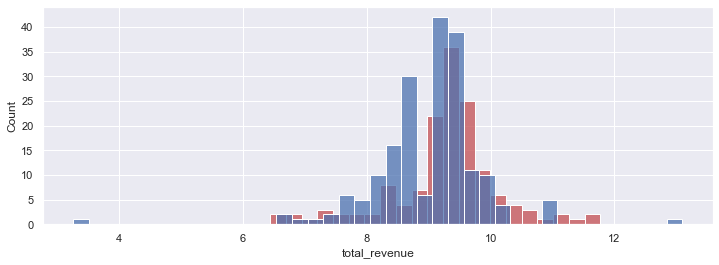

In [138]:
sns.set(rc={'figure.figsize':(12,4)})

sns.histplot(np.log(test_paid_rev), color='r')
sns.histplot(np.log(c1_paid_rev),  )

plt.show()

Test distribution (red) is slightly further to the right than the blue (almost the same)
But, given the t_test and mw tests - there is significant effect. Now let's see the ARPPU values.

In [123]:
print('ARPPU for each group:')
print('Test     : ' + str(test_paid_rev.mean() ))
print('Control_1: ' + str(c1_paid_rev.mean() ))
print('Control_2: ' + str(c2_paid_rev.mean() ))

ARPPU for each group:
Test     : 15759.027397260274
Control_1: 13444.098958333334
Control_2: 10269.72192513369


Test group has higher ARPPU